# Example script for using the ```fit_ringdown_near_EP.py``` module

This fits the ringdown data, as it's taken at the beginning of an degenerate subspace transport experiment.

Despite the fact that I've put "near_EP" in the name, this fit routine should work for any ringdown dataset where we drive (1,0) and then (0,1), i.e. it should be able to fit all the sheet data.

However, the bare membrane parameters are being saved differently in a sheet measurement vs a driven spectroscopy measurement at the beginning of a Berry phase experiment. So you have to load those in differently. The class ```bare_loader``` in the module was written to load in the bare membrane parameters from a sheet measurement, and *should* work for that purpose but specific details may have changed since I last tested it. ```bare_loader``` never gets used in this notebook: the comensurate class for Berry phase experiments is ```guess_loader```

You'll probably have to play with the directories to access the correct background modules/data files. 

This code has been tested on degenerate subspace data from 3/27/2024.


### import modules

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.colors as mcolors

mpl.rcParams["savefig.facecolor"] = 'white'
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

import sys
sys.path.append(sys.path[0].split('20240424')[0] + 'Code')
sys.path.append(sys.path[0].split('example data')[0] + 'analysis')

# sys.path.append(sys.path[0].split('007')[0] + '/007/Yale University/JackHarrisLabs - MIM - NewEP3Exp/Code')
# sys.path.append('D:/Yale University/JackHarrisLabs - MIM - MIM/NewEP3Exp/Code')
import file_handling
import pickle
import time
#mpl.use('Agg')
import os
import pandas as pd
from datetime import datetime 
import time
import fitting.Rotating_frame_fit_routines as rothamfit
# import fit_ringdown_two_prep_one_demod as cfit
import fit_ringdown_near_EP as cfit
# import rotating.rotating_ringdown_spectroscopy_fits_v7g as cfit

### folders and addresses

In [2]:
# name = 'EP sheet try 1'
folder = sys.path[0] # + "\\" + str(name)

bare_guesses_filename = folder + '/initial guesses/initial guesses_0.csv'
folderid = folder + "/randomized id/"

tap_filename = folder + "/tap/summary of dynamics tap_0.csv"

folder_ringdown = folder + "/spectroscopy data/C_avg/"
fubar = "/spectroscopy data/C_avg/"
folderfitname = 'pyfit test 1'
folderfit = file_handling.create_data_directory(fubar + folderfitname)



### load bare ringdowns and guesses

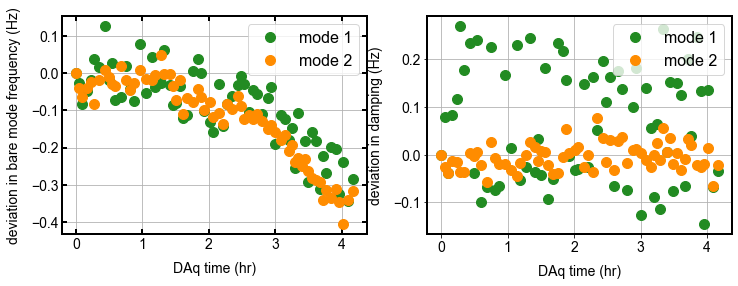

In [3]:
# bare_mode = cfit.load_controlOFF_ringdowns(folderbare, barefilename, folderanalysis, plot = True, save = False)
# [t0, f1start, bf1poly, baregam1, f2start, bf2poly, baregam2] = bare_mode
# print(baregam1, baregam2)

# bare = cfit.bare_loader()
# bare.load_controlOFF_ringdowns (folderbare, barefilename, folderanalysis, plot = True, save = False)
# print(bare.baregam1, bare.baregam2)

guessobj = cfit.guess_loader(bare_guesses_filename)
guessobj.plot_bare(plot = True)

### unramdomize

In [4]:
idtab = np.int32(np.loadtxt(folderid + "idtab_0.txt"))
sortedtab = cfit.make_id(idtab)
# print(idtab)
# print(sortedtab)

pname, _ = file_handling.make_filename('unrandomized', folderid, 'txt')
# file_handling.savetxtdate(pname, sortedtab, delimiter = ' ', header = '', fmt = None, longnumber = False)

### load tap

In [5]:
#import relevant tap csv file
itap = 0
control_params = cfit.load_tap(tap_filename)
[eta, measP1, measP2, setdelta, measP4, setDelta4] = control_params
startpt = len(np.unique(setdelta))
print(eta)
print(startpt)

for i in range(len(measP4)):
    if measP4[i] < 0.1:
        measP4[i] = 0

-50.0
1


### next steps

In [6]:
#system parameters
alpha = 0.847*250/(250 + 250 + 112) #kext_rat
off = -0.03e6#Hz
g1 = 4.51#Hz
g2 = 2.53#Hz
kappa  = 2.37e6#Hz
A1 = 4.3e-6#Hz
A2 = 5.2e-6#Hz
HamiltonianParams = [2*np.pi*kappa, alpha, 2*np.pi*g1,  2*np.pi*g2,  2*np.pi*A1, 2*np.pi* A2]

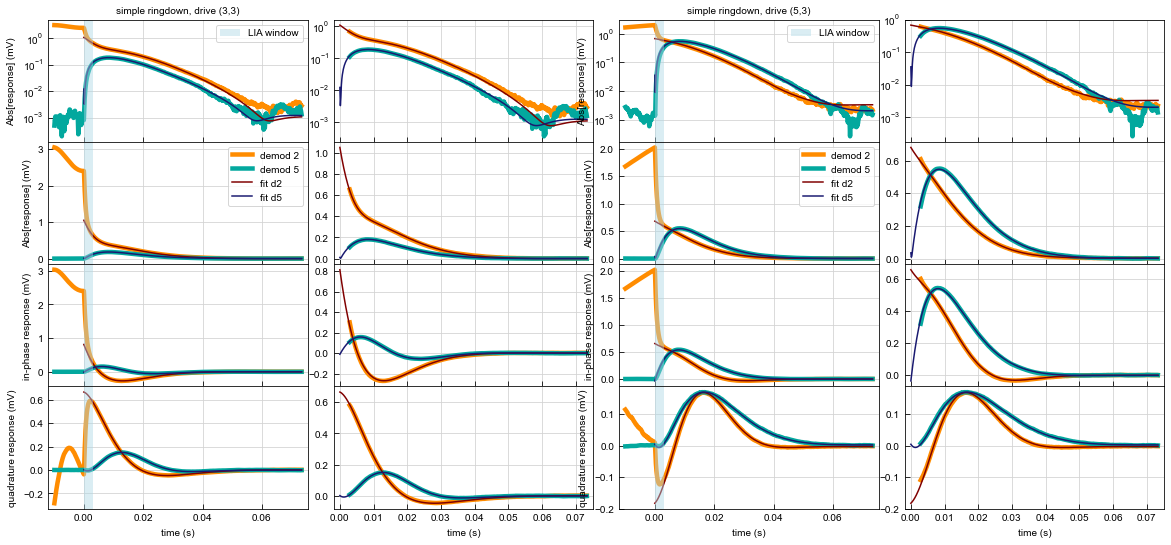

In [7]:
shiftv = 0
i0 = 0

test = cfit.fit_all(folder_ringdown  + 'mode_1_{}_0.csv'.format(sortedtab[i0]), folder_ringdown  + 'mode_2_{}_0.csv'.format(sortedtab[i0]), 
                    guessobj.ith_guess(sortedtab[i0]), shift = [shiftv,shiftv], scaleop = 0)
guess = guessobj.ith_guess(i0)
amp_guess = [3, 1, 1, 1, 3, 1, 0, 0,0]
model = test.prepare_model(amp_guess)

# FR, model = test.dofits(amp_guess)
h, v = test.run_fit_generate_data(amp_guess)
test.plotter.make_theory_curves(test.modelF, test.fit_report)
test.plotter.plot_all(_, _, show = True, save = False)
# test.plotter.plot_all(folderringdown + 'ringdown mode 1_{}.csv'.format(sortedtab[i0]), folderringdown + 'ringdown mode 2_{}.csv'.format(sortedtab[i0]),
#                       show = True, save = False)

# guesss = test.next_guess
# guesssstart = test.next_guess

### iterate

In [11]:
nsets = 67


fittab = np.zeros([nsets,len(v)])
preamble = h
fitpfilename, _ = file_handling.make_filename('ringdown fit', folderfit, 'csv')
np.savetxt(fitpfilename, fittab, header = preamble)
fittab

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
mpl.use('Agg')

for i0 in range(nsets):
    print(i0)
    t1 = time.time()
    test = cfit.fit_all(folder_ringdown  + 'mode_1_{}_0.csv'.format(sortedtab[i0]), folder_ringdown  + 'mode_2_{}_0.csv'.format(sortedtab[i0]), 
                    guessobj.ith_guess(sortedtab[i0]), shift = [shiftv,shiftv], scaleop = 0)
    guess = guessobj.ith_guess(sortedtab[i0])
    amp_guess = [3, 1, 1, 1, 3, 1, 0, 0,0]
    model = test.prepare_model(amp_guess)
    if i0 == 0:
        h, v = test.run_fit_generate_data(amp_guess)
    else:
        h, v = test.run_fit_generate_data(next_amp_guess)
    test.plotter.make_theory_curves(test.modelF, test.fit_report)
    test.plotter.plot_all("ringdown fit_{}".format(i0), folderfit, show = False, save = True)

    fittab[i0,:] = v
    np.savetxt(fitpfilename, fittab, header = preamble, delimiter = ',')
    next_amp_guess = test.next_guess
    t2 = time.time()
    print(t2-t1)


0


7.249743223190308
1
4.762738227844238
2
4.395685911178589
3
6.405324935913086
4
6.762497186660767
5
4.248805284500122
6
6.769335985183716
7
10.120527744293213
8
4.513109922409058
9
4.055959224700928
10
3.931220054626465
11
3.9598710536956787
12
4.006119012832642
13
3.905925989151001
14
3.8260910511016846
15
3.943502902984619
16
3.8727500438690186
17
4.11365008354187
18
3.872988224029541
19
5.055739164352417
20
6.453368186950684
21
7.318063020706177
22
5.711989164352417
23
5.131807088851929
24
4.206108093261719
25
3.982341766357422
26
4.695389032363892
27
4.446866989135742
28
4.547317743301392
29
4.984297037124634
30
5.597688913345337
31
5.300867080688477
32
3.8154733180999756
33
6.209895849227905
34
4.65706205368042
35
8.357861757278442
36
11.733319282531738
37
11.02397108078003
38
6.557033061981201
39
10.10330319404602
40
3.6848042011260986
41
4.678309202194214
42
5.818169116973877
43
5.715265989303589
44
5.530171155929565
45
3.744119167327881
46
3.39384388923645
47
3.583498954772949
